We will now try to design a model while combining all the methods we've experimented with and tested, to get a good model that will be later on compared to the FNO model.

We will use the following methods:

1. Training on noisy data.
2. Training both on 1 and 2 sources.
3. Teacher-Student during training (teacher will be trained on clean data while the student will be trained on a noisy one).
4. Sensor dropout during training, making the model learn without depending on a all sensors data.

We will be using the same architecture as we experimented with, including a 1D CNN encoder, followed by a linear layer and then a 2D CNN decoder.

The input will be the same as before.

TODO: go into more detail here for the final submission

We will start with the model and teacher architectures.

In [123]:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy import signal
from torch.utils.data import random_split
import torch.nn.functional as F
import copy
import scipy.ndimage as ndimage
import scipy.spatial.distance as dist_lib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [116]:
# model architecture
class WaveToMapNet(nn.Module):
    def __init__(self):
        super(WaveToMapNet, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(4, 32, 7, stride=2, padding=3), nn.BatchNorm1d(32), nn.ReLU(),
            nn.Conv1d(32, 64, 5, stride=2, padding=2), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 3, stride=2, padding=1), nn.BatchNorm1d(128), nn.ReLU(),
        )

        # linear layer
        self.fc = nn.Linear(3200, 128 * 8 * 8)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 8, 8)
        x = self.decoder(x)
        return x

In [173]:
# helper layer to help the model avoid ghosting sources

class AddCoords(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_tensor):
        batch_size, _, length = input_tensor.size()
        coords = torch.linspace(-1, 1, length).to(input_tensor.device)
        coords = coords.view(1, 1, length).expand(batch_size, 1, length)

        return torch.cat([input_tensor, coords], dim=1)

In [178]:
class TeacherWaveToMapNet(nn.Module):
    def __init__(self):
        super(TeacherWaveToMapNet, self).__init__()
        self.coord_adder = AddCoords()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(5, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        # pooling
        self.global_pool = nn.AdaptiveAvgPool1d(25)

        # linear layer
        self.fc = nn.Linear(256 * 25, 128 * 16 * 16)

        # decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.coord_adder(x)
        x = self.encoder(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = x.view(x.size(0), 128, 16, 16)
        x = self.decoder(x)
        return x

Now we will generate the data

In [84]:
def generate_unified_data(num_samples=5000, grid_size=32, student_noise=0.001, teacher_noise=0.001, dropout_prob=0.3):
    dt = 0.01
    time_steps = 200
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]]) # 4 Corners


    X_clean = np.zeros((num_samples, 4, time_steps))
    y_locs = np.full((num_samples, 2, 2), -1.0)
    n_sources = np.zeros(num_samples, dtype=int)

    t_wave = np.arange(time_steps) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t_wave**2)) * np.exp(-(np.pi**2)*(f0**2)*(t_wave**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))


    for i in range(num_samples):
        # randomly generate 1 or 2 sources sample
        num_src = 1 if np.random.rand() > 0.5 else 2
        n_sources[i] = num_src

        current_signal = np.zeros((4, time_steps))

        for src_idx in range(num_src):
            src = np.random.rand(2) * [x_max, y_max]
            y_locs[i, src_idx] = src

            for s in range(4):
                dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
                arrival_time = dist / 300.0
                shift_steps = int(arrival_time / dt)
                amplitude = 1.0 / (dist + 1.0)

                if shift_steps < time_steps:
                    valid_len = time_steps - shift_steps
                    current_signal[s, shift_steps:] += wavelet_base[:valid_len] * amplitude

        X_clean[i] = current_signal

    # teacher data part
    teacher_noise_tensor = np.random.normal(0, teacher_noise, X_clean.shape)
    X_teacher = X_clean + teacher_noise_tensor

    # student data part
    student_noise_tensor = np.random.normal(0, student_noise, X_clean.shape)
    X_student = X_clean + student_noise_tensor

    for i in range(num_samples):
        if np.random.rand() < dropout_prob:
            dead_sensor_idx = np.random.randint(0, 4)
            X_student[i, dead_sensor_idx, :] = 0.0

    return (
        torch.tensor(X_student, dtype=torch.float32),
        torch.tensor(X_teacher, dtype=torch.float32),
        torch.tensor(y_locs, dtype=torch.float32),
        torch.tensor(n_sources, dtype=torch.long)
    )

The helper function to display the results in a heatmap, this handles both cases: 1 source or 2 sources

In [5]:
def create_mixed_gaussian_map(source_locs, grid_size=32, sigma=3.0):

    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for i in range(len(source_locs)):
        # source 1
        cx1, cy1 = source_locs[i, 0]

        gauss1 = np.exp(-((xx - cx1)**2 + (yy - cy1)**2) / (2 * sigma**2))

        # source 2 if exists
        cx2, cy2 = source_locs[i, 1]

        # if there's only 1 source
        if cx2 == -1:
            combined = gauss1

        # if there are 2 sources
        else:
            gauss2 = np.exp(-((xx - cx2)**2 + (yy - cy2)**2) / (2 * sigma**2))
            combined = np.maximum(gauss1, gauss2)

        maps.append(combined)

    return np.array(maps)

Generating data and declaring the models

In [179]:
# models

CNN_model = WaveToMapNet()
teacher_model = TeacherWaveToMapNet()

In [176]:
X_s_raw, X_t_raw, Y_coords, n_sources = generate_unified_data(num_samples=5000, grid_size=32)

Y_heatmaps_np = create_mixed_gaussian_map(Y_coords.numpy(), grid_size=32, sigma=3.0)
Y_heatmaps = torch.tensor(Y_heatmaps_np, dtype=torch.float32).unsqueeze(1)

# split 80/10/10
N = len(X_s_raw)
indices = torch.randperm(N)

n_train = int(0.8 * N)
n_val = int(0.1 * N)
n_test = N - n_train - n_val

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

# split all data
X_s_train, X_s_val, X_s_test = X_s_raw[train_idx], X_s_raw[val_idx], X_s_raw[test_idx]
X_t_train, X_t_val, X_t_test = X_t_raw[train_idx], X_t_raw[val_idx], X_t_raw[test_idx]

Y_c_train, Y_c_val, Y_c_test = Y_coords[train_idx], Y_coords[val_idx], Y_coords[test_idx]
Y_h_train, Y_h_val, Y_h_test = Y_heatmaps[train_idx], Y_heatmaps[val_idx], Y_heatmaps[test_idx]
n_src_train, n_src_val, n_src_test = n_sources[train_idx], n_sources[val_idx], n_sources[test_idx]

# normalize data
norm_s = torch.max(torch.abs(X_s_train))
X_s_train = X_s_train / norm_s
X_s_val   = X_s_val   / norm_s
X_s_test  = X_s_test  / norm_s

# normalize teacher data
norm_t = torch.max(torch.abs(X_t_train))
X_t_train = X_t_train / norm_t
X_t_val   = X_t_val   / norm_t
X_t_test  = X_t_test  / norm_t

# creating dataloaders
train_data = TensorDataset(X_s_train, X_t_train, Y_c_train, Y_h_train, n_src_train)
val_data   = TensorDataset(X_s_val,   X_t_val,   Y_c_val,   Y_h_val,   n_src_val)
test_data  = TensorDataset(X_s_test,  X_t_test,  Y_c_test,  Y_h_test,  n_src_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)

We will now train the teacher model, followed by the CNN student model, added weight decay since the teacher model originally overfitted hard

In [115]:
def train_teacher(model, train_loader, val_loader, epochs=30, lr=0.001):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
  criterion = nn.MSELoss()
  best_params = copy.deepcopy(model.state_dict())
  min_loss = float('inf')
  for epoch in range(epochs):
      model.train()
      running_loss = 0.0

      for _, inputs, _, target_heatmaps, n_src in train_loader:
          inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, target_heatmaps)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      avg_loss = running_loss / len(train_loader)
      if (epoch+1) % 5 == 0:
          print(f"Teacher Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

  print("Training complete, Validating now")

  val_loss = 0.0
  model.eval()
  with torch.no_grad():
      for _, inputs, _, target_heatmaps, n_src in val_loader:
          inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)
          val_loss += criterion(model(inputs), target_heatmaps).item()

          # save best params during training
          if val_loss < min_loss:
            best_params = copy.deepcopy(model.state_dict())
            min_loss = val_loss

  print(f"Teacher Validation Loss: {val_loss/len(val_loader):.6f}")
  model.load_state_dict(best_params) # load best params


In [180]:
# train the teacher:
train_teacher(teacher_model, train_loader, val_loader, epochs=30, lr=0.001)

Teacher Epoch 5/30 | Loss: 0.005906
Teacher Epoch 10/30 | Loss: 0.004046
Teacher Epoch 15/30 | Loss: 0.003450
Teacher Epoch 20/30 | Loss: 0.003197
Teacher Epoch 25/30 | Loss: 0.003068
Teacher Epoch 30/30 | Loss: 0.002920
Training complete, Validating now
Teacher Validation Loss: 0.004156


In [11]:
# at the start we should rely more heavily on the teacher, and over time (epochs), the studnet would rely more on itself
# this helper function implements this logic

def get_alpha(epoch, epochs):
  starting_alpha = 0.8
  min_alpha = 0.1 # the lowest we will go
  epoch_decay_limit = int(0.8 * epochs)
  if epoch >= epochs:
    return min_alpha

  progress = epoch / epoch_decay_limit
  return starting_alpha - (progress * (starting_alpha - min_alpha))

In [147]:
def train_student(model, teacher_model, train_loader, val_loader, epochs=30, lr=0.001):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  best_params = copy.deepcopy(model.state_dict())
  min_loss = float('inf')
  teacher_model.eval()

  for epoch in range(epochs):
      alpha = get_alpha(epoch, epochs)
      model.train()
      running_loss = 0.0

      for inputs, teacher_inputs, _, target_heatmaps, n_src in train_loader:
          inputs, teacher_inputs, n_src, target_heatmaps = inputs.to(device), teacher_inputs.to(device), n_src.to(device), target_heatmaps.to(device)

          # add noise to student inputs
          noise = torch.randn_like(inputs) * 0.05
          student_inputs = inputs + noise

          # teacher evaluation
          with torch.no_grad():
              teacher_preds = teacher_model(teacher_inputs)

          student_preds = model(student_inputs)

          # calculate loss
          loss_truth = criterion(student_preds, target_heatmaps)
          loss_distill = criterion(student_preds, teacher_preds)

          loss = (1 - alpha) * loss_truth + alpha * loss_distill

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      if (epoch+1) % 5 == 0:
          print(f"Distill Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.6f}")

  print("Training complete, Validating now")
  val_loss = 0.0
  model.eval()
  with torch.no_grad():
      for _, inputs, _, target_heatmaps, n_src in val_loader:
          inputs, n_src, target_heatmaps = inputs.to(device), n_src.to(device), target_heatmaps.to(device)
          val_loss += criterion(model(inputs), target_heatmaps).item()

          # save best params during training
          if val_loss < min_loss:
            best_params = copy.deepcopy(model.state_dict())
            min_loss = val_loss

  print(f"Student Validation Loss: {val_loss/len(val_loader):.6f}")
  model.load_state_dict(best_params) # load best params

In [181]:
# train the student
train_student(CNN_model, teacher_model, train_loader, val_loader, epochs=30, lr=0.001)

Distill Epoch 5/30 | Loss: 0.019791
Distill Epoch 10/30 | Loss: 0.017953
Distill Epoch 15/30 | Loss: 0.017892
Distill Epoch 20/30 | Loss: 0.017997
Distill Epoch 25/30 | Loss: 0.018024
Distill Epoch 30/30 | Loss: 0.018137
Training complete, Validating now
Student Validation Loss: 0.011383


Let us test the final model

In [149]:
def test_model(model, test_loader):
  model.eval()

  inputs, _, _, target_heatmaps, n_src = next(iter(test_loader))
  inputs = inputs.to(device)
  target_heatmaps = target_heatmaps.to(device)
  n_src = n_src.to(device)

  with torch.no_grad():
      pred_check = model(inputs)

  # Plot 3 random examples to be sure
  fig, axes = plt.subplots(4, 2, figsize=(12, 10))

  for i in range(4):


      # ground truth
      axes[i, 0].imshow(target_heatmaps[i, 0].cpu(), origin='lower', extent=[0,32,0,32])
      axes[i, 0].set_title("True Sources")

      # model prediction
      axes[i, 1].imshow(pred_check[i, 0].cpu(), origin='lower', extent=[0,32,0,32])
      axes[i, 1].set_title("Model Prediction")

  plt.tight_layout()
  plt.show()

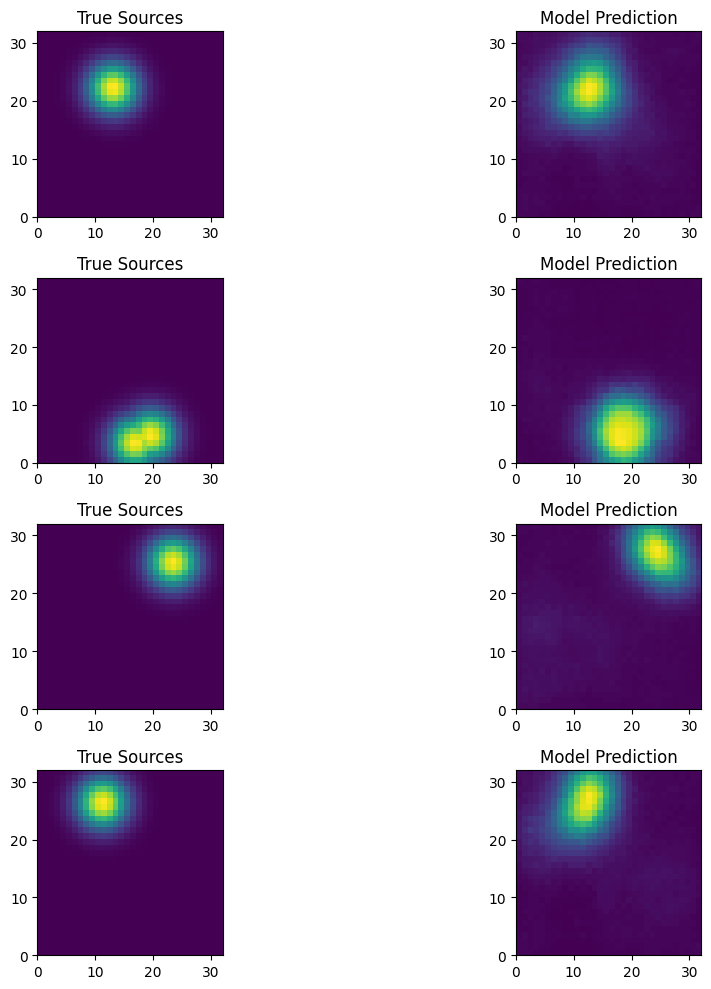

In [182]:
test_model(CNN_model, test_loader)

To be more test the performance of the model in a more precise method, we will calculate the distance between the peaks of each sample compared to the ground truth

In [124]:
def compare_peak_sets(true_peaks, pred_peaks):
    n_true = len(true_peaks)
    n_pred = len(pred_peaks)

    # both peaks are empty
    if n_true == 0 and n_pred == 0:
        return 0.0, 0

    # one of the peaks is empty
    if n_true == 0 or n_pred == 0:
        return 999.0, abs(n_true - n_pred) # Return huge error

    # both present (1 peak each)
    if n_true == 1 and n_pred == 1:
        dist = np.linalg.norm(true_peaks[0] - pred_peaks[0])
        return dist, 0

    # 2 peaks each, checking permutations
    if n_true == 2 and n_pred == 2:
        # peaks positions fit
        d1 = np.linalg.norm(true_peaks[0] - pred_peaks[0]) + \
             np.linalg.norm(true_peaks[1] - pred_peaks[1])

        # peaks positions dont fit
        d2 = np.linalg.norm(true_peaks[0] - pred_peaks[1]) + \
             np.linalg.norm(true_peaks[1] - pred_peaks[0])

        return min(d1, d2) / 2.0, 0

    # mismatch between 1 peak each

    if n_true != n_pred:
        # calculate all possible distances and return the minimum
        d_matrix = dist_lib.cdist(true_peaks, pred_peaks)
        min_dist = np.min(d_matrix)

        return min_dist, abs(n_true - n_pred)

In [125]:
def get_peaks_subpixel(heatmap, threshold=0.5, grid_size=32, physical_size=100.0):
    heatmap = heatmap.copy()
    heatmap[heatmap < threshold] = 0

    labeled, num_objects = ndimage.label(heatmap > 0)
    peaks = []

    if num_objects == 0:
        return np.empty((0, 2)) # return empty array if no peaks found

    for i in range(1, num_objects + 1):
        # find center of the gaussian
        cy, cx = ndimage.center_of_mass(heatmap, labeled, i)

        # convert to meters
        # cx is column (x), cy is row (y)
        scale = physical_size / grid_size
        peaks.append([cx * scale, cy * scale])

    # convert to np array
    peaks = np.array(peaks)

    if len(peaks) > 0:
        peaks = peaks[np.argsort(peaks[:, 0])]

    return peaks

In [185]:
def test_model_peaks(model, test_loader):
    model.eval()

    print("-" * 65)
    print(f"{'True Position':<30} | {'Pred Position':<30} | {'Error (m)':<10}")
    print("-" * 65)

    data_iter = iter(test_loader)
    i = 0
    while i < 5:
        try:
            # get the next batch
            batch = next(data_iter)
            x_test_batch, _, _, y_test_batch, n_src_batch = batch

        except StopIteration:
            break

        x_input = x_test_batch[0].unsqueeze(0).to(device)

        true_map = y_test_batch[0, 0].cpu().numpy()
        pred_map = model(x_input)[0, 0].cpu().detach().numpy()

        # get the peaks
        true_peaks = get_peaks_subpixel(true_map, threshold=0.5)
        pred_peaks = get_peaks_subpixel(pred_map, threshold=0.3)

        # compare the peaks
        error, count_diff = compare_peak_sets(true_peaks, pred_peaks)

        if count_diff > 0:
          i -= 1
          continue

        t_str = str(np.round(true_peaks, 1)).replace('\n', '')
        p_str = str(np.round(pred_peaks, 1)).replace('\n', '')

        print(f"{t_str:<30} | {p_str:<30} | {error:.4f}")

In [186]:
test_model_peaks(CNN_model, test_loader)

-----------------------------------------------------------------
True Position                  | Pred Position                  | Error (m) 
-----------------------------------------------------------------
[[39.6 68. ]]                  | [[38.  66.7]]                  | 2.1125
[[12.8  5. ]]                  | [[9.8 7.9]]                    | 4.1988
[[11.9 13.8] [60.4 90.2]]      | [[ 8.5 11.4] [61.6 84.6]]      | 4.9078
[[20.3 85. ]]                  | [[20.  87.4]]                  | 2.3723
[[78.8  7.1]]                  | [[83.  13.1]]                  | 7.3618


As we can see, for some cases the error is less than a pixel (a single pixel size is 3.125m), and for others the error is larger. It is hard for the model to generelize and it performs less well on this mixed data compared to a model that was trained only on 1 source or 2 sources, especially since we also gave it 5000 samples of mixed sources amount data

To later compare to the FNO, lets review the models sizes and number of parameters

In [169]:
def get_model_size_and_n_params(model, model_name):
  num_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  param_size = 0
  for param in model.parameters():
    param_size += param.nelement() * param.element_size()
  buffer_size = 0
  for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()
  size_all_mb = (param_size + buffer_size) / 1024 ** 2
  print(f"{model_name} size: {size_all_mb:.2f} MB")
  print(f"number of trainable params: {num_trainable_params}")
  return size_all_mb, num_trainable_params

In [184]:
CNN_size, CNN_params = get_model_size_and_n_params(CNN_model, "CNN Student Model")
print("=" * 100)
teacher_size, teacher_params = get_model_size_and_n_params(teacher_model, "Teacher Model")
print("=" * 100)
print(f"total number of params is {CNN_params + teacher_params} and total size is {CNN_size + teacher_size} MB")

CNN Student Model size: 100.98 MB
number of trainable params: 26469505
Teacher Model size: 801.25 MB
number of trainable params: 210040897
total number of params is 236510402 and total size is 902.2229995727539 MB
